# Homework Set 5 -- Monte Carlo I


**Unless explicitly forbidden, you can use any standard python function from `numpy`/`scipy`/`pandas`/`matplotlib` or the lectures to solve homework problems. DO NOT use other packages like `Quantlib`/`Quandl`/`portfoliolab`/`etc`.**

## Problem 1 (50 points)

A basket (put or call) option is an option on a basket of securities, commodities, or currencies (it is similar to an option on index).

Who uses basket options?
* Multinational corporations that want to hedge against a number of FX risks.
* Investors who wish to have a broad exposure to (or hedge) particular portfolios, industry sectors, or countries.

Index options are an alternative to basket options, but if the index does not match the desired portfolio there will be significant tracking error risk that can cost more than the additional cost of the basket option. Another alternative is a collection of individual stock options, but this may be more expensive due to transaction costs and because the implied volatility of each option includes a large component of specific stock risk which may be diversified in a basket.

The discounted payoff function is given by:

$$
V_{\text{basket}} =
e^{-rT} \left( \sum_i^m x_i S_i(T) - K \right)^+
$$

where $S_i(t)$ is the asset value at time $t$ of asset $i$, $m$ is the number of assets in the basket, $x_i$, is the weight of asset $i$ in the basket (which does not change over time), $K$ is the strike price, $r$ is the risk-free rate, and $T$ is the time to maturity.

You have a client that wants to protect their portfolio of tech stocks for the next year by purchasing an at-the-money basket put option on the five stocks in the portfolio (IBM, NFLX, MSFT, FB, and AAPL), where the stocks are equally-weighted. Using Monte-Carlo, compute the price (along with the estimated error) of the basket option for your client. (You may assume that the risk-free rate is 2% and you can use the last year of daily prices to compute the correlation matrix). **NB**: Obviously you need to provide your code.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

tickers = ['IBM','NFLX','MSFT','META','AAPL']
end_date = datetime.today()
data = yf.download(tickers, start='2023-01-01', end=end_date.strftime('%Y-%m-%d'), auto_adjust=True)['Close']
ret = data.pct_change()
C = ret.corr()
data

[*********************100%%**********************]  5 of 5 completed


,AAPL,IBM,META,MSFT,NFLX
Date,,,,,
2023-01-03,124.216301,133.634201,124.607788,237.036011,294.950012
2023-01-04,125.497505,134.625488,127.235008,226.667282,309.410004
2023-01-05,124.166641,133.218826,126.805458,219.949387,309.700012
2023-01-06,128.735245,135.663986,129.882202,222.541550,315.549988
2023-01-09,129.261627,135.522354,129.332779,224.708282,315.170013
...,...,...,...,...,...
2024-02-26,181.160004,184.130005,481.739990,407.540009,587.650024
2024-02-27,182.630005,184.869995,487.049988,407.480011,601.669983
2024-02-28,181.419998,185.300003,484.019989,407.720001,596.479980


In [2]:
C

,AAPL,IBM,META,MSFT,NFLX
AAPL,1.000000,0.185241,0.459788,0.541332,0.392676
IBM,0.185241,1.000000,0.103267,0.120123,0.141286
META,0.459788,0.103267,1.000000,0.519568,0.292733
MSFT,0.541332,0.120123,0.519568,1.000000,0.378127
NFLX,0.392676,0.141286,0.292733,0.378127,1.000000


In [4]:
T = 252
K = data.iloc[-1].mean()
r = 0.02
stds = np.array(ret.std()) * np.sqrt(T)
L = np.linalg.cholesky(C)

def MC_basket():
    res = np.zeros((5,253))
    res[:,0] = data.iloc[-1]
    X = np.random.randn(5,252)
    W_t = L @ X
    for col in range(1,253):
        res[:,col] = res[:,col-1]*np.exp((r-0.5*stds**2)/252+stds/np.sqrt(252)*W_t[:,col-1])
    final_price = res[:,-1].mean()
    return  np.exp(-r) * max(K - final_price, 0) 

ans = []
N = 10000
for i in range(N):
    ans.append(MC_basket()) 
    
print('Simulated price for the bastket put option is $', round(np.mean(ans),4))
print('MC error is', round(np.sqrt(np.var(ans)/N),4))


Simulated price for the bastket put option is $ 31.6454
MC error is 0.4217


## Problem 2 (50 points)

The square root diffusion process was first proposed by [Cox, Ingersoll, and Ross (1985)](https://www.sciencedirect.com/science/article/abs/pii/0304405X94900167) to model interest rates and has been quite popular for other uses. For example, it was applied by [Heston (2015)](https://academic.oup.com/rfs/article-abstract/6/2/327/1574747?redirectedFrom=fulltext&login=false) to model stochastic volatility in option pricing. The model is given by the following stochastic differential equation:

$$
d x_t = \kappa ( \theta - x_t ) dt + \sigma \sqrt{x_t} dZ_t
$$

where $x_t$ is the process level at time $t$, $\kappa$ is the mean-reversion factor, $\theta$ is the long term mean of the process, $\sigma$ is the constant volatility, and $Z$ is standard Brownian motion.

While it is well known that the values of $x_t$ are distributed chi-squared, it is often discretized and approximated using a normal distribution. This is what is known as the Euler discretization scheme (this is the general technique used in the course so far). The CIR process can be discretized (using the Euler scheme) as:  

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t
$$

In this case, the use of a normal distribution creates a slight problem. While the square-root diffusion requires that the values of $x_t$ be strictly positive, the use of the normal distribution produces both positive **and** negative values. In the simulation, this can be "fixed" two ways:
1. *Truncation method*: where we use $x^+ = \max(x,0)$:

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1}^+ ) \delta t + \sigma \sqrt{x_{t-1}^+ \delta t} z_t
$$

2. *Reflection method*: where we use a positive value "as is" and "reflect" a negative value by changing the sign (alternatively, one could take an absolute value):

$$
x_t = \begin{cases}
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $>0$}\\
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t - \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $<0$}
\end{cases}
$$

There is a third method, the **exact** discretization scheme, based on the noncentral chi-squared distribution $\chi_d^2$, which can be written:

$$
x_t = \frac{\sigma^2 (1-e^{-\kappa \delta t})}{4 \kappa} 
\chi_d^2 \bigg( \frac{4 \kappa e^{-\kappa \delta t}}{\sigma^2(1-e^ {-\kappa \delta t})}x_{t-1} \bigg)
$$

where the noncentral parameter is in the parenthesis for the $\chi^2$ distribution, and the degrees of freedom are given by:

$$
d = \frac{4 \theta \kappa}{\sigma^2}
$$

(a) Develop the `python` code for each of these three methods and test the pricing using the parameters $T=1$, $x_0 = 0.1$, $\kappa = 0.5$, $\theta = 0.1$, and $\sigma = 0.8$ (reporting the errors with each). You want to make sure that you are comparing apples-to-apples: same seed (=2), same parameters, same number of time periods, and same number of paths.
(b) Plot the time series of the truncated value against the reflecting value. Do you have any observations?
(c) Compute the cost of running each of the methods and compare. Which is better and why?

## (a)

In [22]:
import numpy as np

np.random.seed(seed=2)
n_paths = 10000
n_steps = 252
x0 = 0.1
T = 1
k = 0.5
theta = 0.1
sigma = 0.8
delta_t = T / n_steps
X = np.random.randn(n_paths,n_steps)

# Truncation method
def MC_truncate():
    res = np.zeros((n_paths,n_steps+1))
    res[:,0] = x0
    for col in range(1,n_steps+1):
        prev = res[:,col-1]
        res[:,col] = prev+k*(theta-np.maximum(prev,0))*delta_t+sigma*np.sqrt(np.maximum(prev,0)*delta_t)*X[:,col-1]
    return res

# Reflection method
def MC_reflect():
    res = np.zeros((n_paths,n_steps+1))
    res[:,0] = x0
    for col in range(1,n_steps+1):
        prev = res[:,col-1]
        val1 = prev+k*(theta-prev)*delta_t+sigma*np.sqrt(prev*delta_t)*X[:,col-1] 
        val2 = prev+k*(theta-prev)*delta_t-sigma*np.sqrt(prev*delta_t)*X[:,col-1] 
        val = np.zeros(n_paths)
        val[np.where(val1>0)] = val1[np.where(val1>0)]
        val[np.where(val1<0)] = val2[np.where(val1<0)]
        res[:,col] = val
    return res


def MC_exact():
    res = np.zeros((n_paths,n_steps+1))
    res[:,0] = x0
    coef = sigma**2*(1-np.exp(-k*delta_t))/4/k
    df = 4*theta*k/sigma**2
    for col in range(1,n_steps+1):
        nc = 4*k*np.exp(-k*delta_t)/sigma**2/(1-np.exp(-k*delta_t)) * res[:,col-1]
        res[:,col] = coef*np.random.noncentral_chisquare(df,nc)
    return res

In [23]:
trun_data = MC_truncate()
ref_data = MC_reflect()
exact_data = MC_exact()
print('Truncation method approxiamtes X_T as:', trun_data[:,-1].mean())
print('Reflection method approxiamtes X_T as:', ref_data[:,-1].mean())
print('Exact method approxiamtes X_T as:', exact_data[:,-1].mean())

Truncation method approxiamtes X_T as: 0.09907131550151932
Reflection method approxiamtes X_T as: 0.13466321003161502
Exact method approxiamtes X_T as: 0.09955368768720893


## (b) 

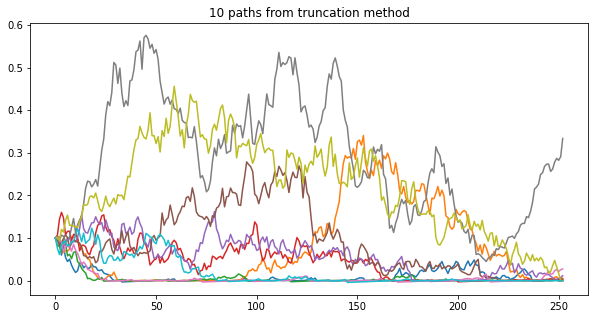

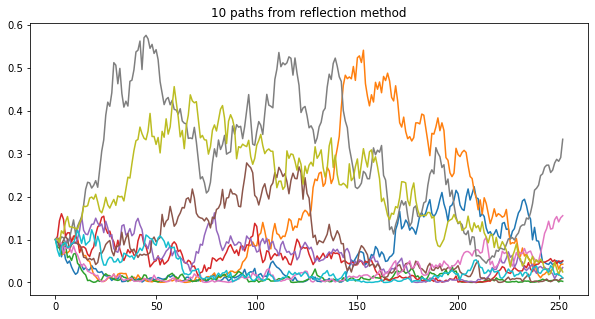

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(trun_data[i])
plt.title('10 paths from truncation method')
plt.show()
ref_data = MC_reflect()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(ref_data[i])
plt.title('10 paths from reflection method')
plt.show()

#### We can see that if $x_t$ are positive, then the two methods will gengerate the same paths; however, reflection method can generate paths with values larger tha those in paths from the truncation method. The reason is simply that truncation method set negative values to 0 while reflection method reflect it to positive values.

## (c)

In [18]:
%%timeit 
trun_data = MC_truncate()

56.9 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit 
ref_data = MC_reflect()

100 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit 
exact_data = MC_exact()

297 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


####   Truncation method is the fastest, reflection method being the second and the exact discretization scheme is the slowest. Both  truncation method and reflection method can generate (n_paths $\times$ n_steps) standard normal samples once, but reflection method needs to judge whether the $x_t$ is positive or negative in each time step, which takes time. The exact discretization scheme should be the slowest and cost most since the noncentral parameter depends on the previous value of $x_t$, which means we have to sample on each time step and for each path, taking more time.